In [123]:
import numpy as np
import pandas as pd

import requests
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

sys.path.append('../../src/')
import toolbox

In [5]:
r = requests.get('http://data.thecrix.de/data/crix11.json').json()
VCRIX = pd.DataFrame(r)
VCRIX.date = pd.to_datetime(VCRIX.date)

# VCRIX.n = VCRIX.n.astype(np.int)

_id = VCRIX.date > '20180614'

VCRIX = VCRIX.loc[_id, :]

VCRIX.n = list(range(len(VCRIX)))

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


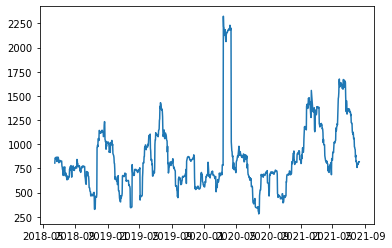

In [6]:
plt.plot(VCRIX.date, VCRIX.vcrix)


# thres = np.quantile(VCRIX.vcrix , 0.90)


thres = 1000
i = VCRIX.vcrix >=thres
# plt.scatter(VCRIX.date.loc[i], VCRIX.vcrix.loc[i], color='red')

stress_period = VCRIX.loc[i, :]

# for i in range(len(stress_period)-1):
#     start = training_Clayton.Date.iloc[i]
#     end =  training_Clayton.Date.iloc[i+1]
#     _end = end
#     plt.axvspan(start, end,facecolor='black', alpha=.2)

In [7]:
stress_period.date

1459   2018-11-26
1460   2018-11-27
1461   2018-11-28
1462   2018-11-29
1463   2018-11-30
          ...    
2424   2021-07-18
2425   2021-07-19
2426   2021-07-20
2427   2021-07-21
2428   2021-07-22
Name: date, Length: 283, dtype: datetime64[ns]

In [8]:
last_n = stress_period.iloc[0,:].n

start_arr = [stress_period.iloc[0,:].date]
end_arr = []

for row_i in range(1, len(stress_period)-2):
    
    last_n = stress_period.iloc[row_i-1,:].n
    n  = stress_period.iloc[row_i,:].n
    next_n = stress_period.iloc[row_i+1,:].n
    next_next_n = stress_period.iloc[row_i+2,:].n

    
    if (next_n-n>1):
        end_arr.append(stress_period.iloc[row_i,:].date)

    if n-last_n>1:
        start_arr.append(stress_period.iloc[row_i,:].date)

        
end_arr.append(stress_period.iloc[-1,:].date)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


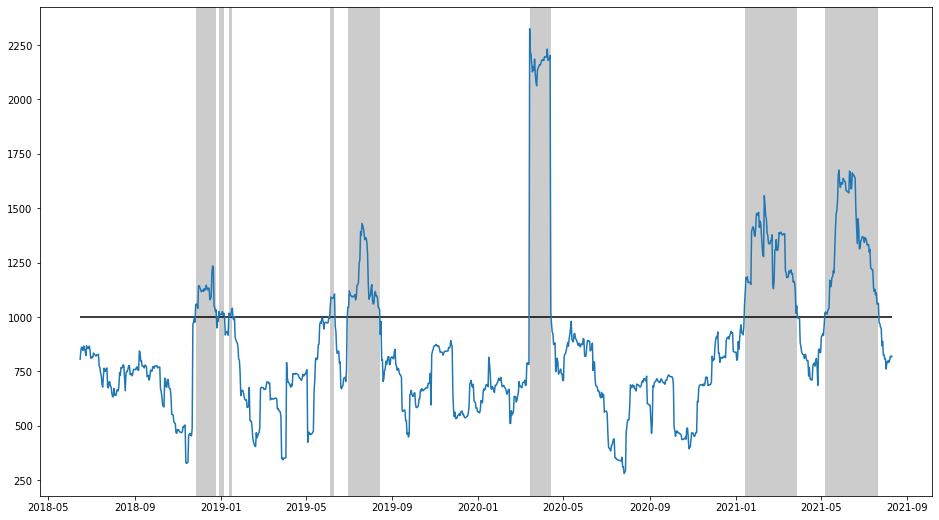

In [9]:
plt.figure(figsize=(16,9))
plt.plot(VCRIX.date, VCRIX.vcrix)

plt.hlines(y=thres, xmin=VCRIX.iloc[0,:].date, xmax=VCRIX.iloc[-1,:].date)


# plt.plot(stress_period.date, stress_period.vcrix)
for i in range(len(start_arr)):
    start = start_arr[i]
    end =  end_arr[i]
    plt.axvspan(start, end, facecolor='black', alpha=.2)

In [10]:
np.array(end_arr)  - np.array(start_arr) 

array([Timedelta('29 days 00:00:00'), Timedelta('7 days 00:00:00'),
       Timedelta('5 days 00:00:00'), Timedelta('0 days 00:00:00'),
       Timedelta('0 days 00:00:00'), Timedelta('6 days 00:00:00'),
       Timedelta('45 days 00:00:00'), Timedelta('30 days 00:00:00'),
       Timedelta('75 days 00:00:00'), Timedelta('76 days 00:00:00')],
      dtype=object)

In [11]:
for i in range(len(start_arr)):
    print(start_arr[i], end_arr[i])

2018-11-26 00:00:00 2018-12-25 00:00:00
2018-12-29 00:00:00 2019-01-05 00:00:00
2019-01-12 00:00:00 2019-01-17 00:00:00
2019-01-20 00:00:00 2019-01-20 00:00:00
2019-06-03 00:00:00 2019-06-03 00:00:00
2019-06-05 00:00:00 2019-06-11 00:00:00
2019-06-30 00:00:00 2019-08-14 00:00:00
2020-03-14 00:00:00 2020-04-13 00:00:00
2021-01-13 00:00:00 2021-03-29 00:00:00
2021-05-07 00:00:00 2021-07-22 00:00:00


In [328]:
result_names = ['BBT_Tiingo',
                'BBT_future_Tiingo_ada', 
                'BBT_future_Tiingo_eth',
                'BBT_future_Tiingo_ltc',
                'BBT_future_Tiingo_xrp',
                'BBT_future_BITX',
                'BBT_future_BITW20', 
                'BBT_future_BITW70', 
                'BBT_future_BITW100', 
                'BBT_future_CRIX']

# result_names = ['BBT_future_CRIX']

coin_names = ['bitcoin', 'ada', 'eth', 'ltc', 'xrp',
              'BITX', 'BITW20', 'BITW70', 'BITW100', 'CRIX']

i = 5
data_name = result_names[i]
coin_name = coin_names[i]
# objective = 'ERM k=10'
objective = 'VaR q=0.05'
print(data_name, coin_name, objective)

rh_df = pd.read_csv('../../results/%s/MM/rh_%s_copula_selection.csv'%(data_name, objective))

BBT_future_BITX BITX VaR q=0.05


In [329]:
rh_df.Date = pd.to_datetime(rh_df.Date.apply(lambda x: x[:10]))

In [330]:
s_id = rh_df.Date.apply(lambda x: x in list(stress_period.date))

In [331]:
import os, sys
os.listdir()

['.DS_Store',
 'San-Lin Chung; Pai-Ta Shih; Wei-Che Tsai (2010). A modified static hedging method for continuous barrier options. , 30(12), 1150–1166. doi-10.1002:fut.20451 .pdf',
 'risk_period.ipynb',
 'Summary_statistics.ipynb',
 'LL_NIG.csv',
 'senity_check.ipynb',
 'LL_withNIG_Crix.csv',
 'Gumbel_animation',
 '.ipynb_checkpoints',
 'Hedging_Effectiveness.ipynb',
 'copula_selection.ipynb',
 'LL_withNIG_Crix.html',
 'plots',
 'sensitivity_analysis']

In [332]:
train_path = '../../processed_data/%s/train/'%data_name
test_path = '../../processed_data/%s/test/'%data_name

files = [f for f in os.listdir(train_path) if f.endswith('.csv')]

test_arr = []

for f in files:
    train = pd.read_csv(train_path+f)
    test = pd.read_csv(test_path+f)
    rs = train.iloc[:,-1]
    rf = train.iloc[:,-2]
    rho = np.corrcoef(rs,rf)[0,1]
    rs_std = np.std(rs)
    rf_std = np.std(rf)
    h = rho*rs_std/rf_std
    test.loc[:,'h_CH'] = h
    test_arr.append(test)

In [333]:
CH = pd.concat(test_arr)
CH.Date = pd.to_datetime(CH.Date)
CH = CH.sort_values('Date', ascending=False)

CH.reset_index(drop=True, inplace=True)
CH.loc[:,'rh'] = CH.loc[:,'log return %s'%coin_name] - CH.loc[:,'h_CH']* CH.loc[:,'log return future']

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-pack

avg h 
copula     :0.946 
cross hedge:0.953


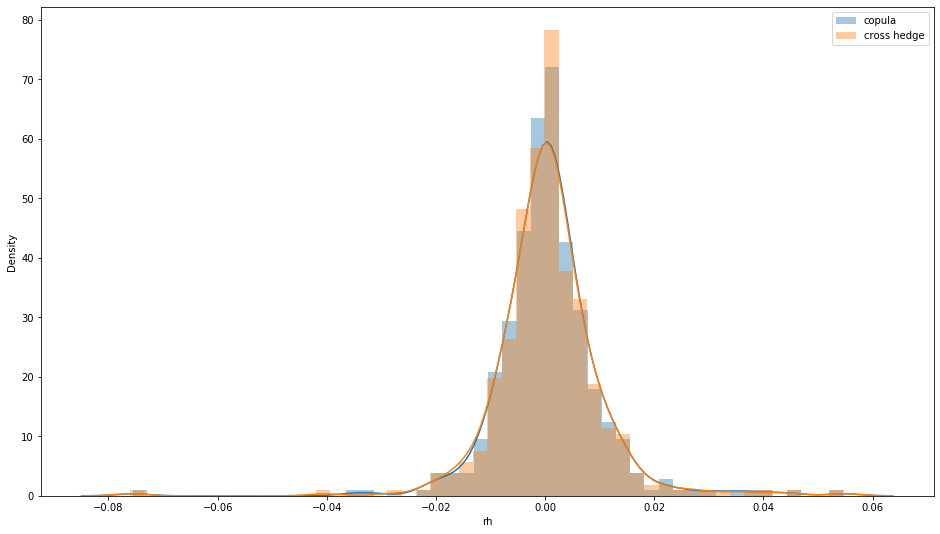

In [334]:
plt.figure(figsize=(16,9))

# sns.distplot(rh_df.new_rh)
sns.distplot(rh_df.rh, label='copula')
sns.distplot(CH.rh, label='cross hedge')
plt.legend()
print('avg h', '\ncopula     :%.3f'%np.mean(rh_df.h),  '\ncross hedge:%.3f'%np.mean(CH.h_CH))

In [335]:
def risk_statistics(rh, name):

    ERM = toolbox.ERM_estimate_trapezoidal(10, rh)
    ES1 = toolbox.ES(0.01, rh)
    ES5 = toolbox.ES(0.05, rh)
    VaR1 = toolbox.VaR(0.01, rh)
    VaR5 = toolbox.VaR(0.05, rh)
    Var = toolbox.Variance(rh)
    
    _dict = {'ERM':ERM, 'ES1':ES1, 'ES5':ES5, 'VaR1':VaR1, 
             'VaR5':VaR5, 'Var':Var}
    
    return pd.DataFrame([_dict], [name])

In [338]:
print(coin_name, objective)
risk_statistics(rh_df.rh, 'copula')\
    .append(risk_statistics(CH.rh, 'cross hedge'))\
    .append(risk_statistics(rh_df.rs, 'spot'))

BITX VaR q=0.05


,ERM,ES1,ES5,VaR1,VaR5,Var
copula,0.012060,0.037006,0.020562,0.020522,0.011741,0.000097
cross hedge,0.012370,0.037775,0.021054,0.021001,0.012867,0.000098
spot,0.066617,0.177928,0.116244,0.142476,0.065817,0.002086


In [339]:
print(coin_name, objective)
risk_statistics(rh_df.loc[s_id, 'rh'], 'copula in stress period')\
    .append(risk_statistics(CH.loc[s_id,'rh'], 'cross hedge in stress period'))\
    .append(risk_statistics(rh_df.loc[s_id,'rs'], 'spot in stress period'))

BITX VaR q=0.05


,ERM,ES1,ES5,VaR1,VaR5,Var
copula in stress period,0.017779,0.075528,0.036972,0.040908,0.019570,0.000202
cross hedge in stress period,0.018160,0.076033,0.037775,0.045376,0.020252,0.000205
spot in stress period,0.080025,0.161541,0.136882,0.145495,0.113336,0.003409
